# AHRQ SDOH Census Tract

## Reading in AHRQ data

In [53]:
import pandas as pd
import collections
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
path = 'data/sdoh_2020_tract_1_0.xlsx'
dfs = pd.read_excel(
        path,
        sheet_name = None,
        dtype = str,
        na_filter = False,
        nrows = 1000,
)

for name, df in dfs.items():
    print(name)
    with pd.option_context('display.max_columns', None):
        display(df.head())

layout_df = dfs['Layout']

Layout


,name,label,type,length,format
0,YEAR,SDOH file year,num,3,4.
1,TRACTFIPS,State-county-census tract FIPS Code (11-digit),char,11,$11.
2,COUNTYFIPS,State-county FIPS Code (5-digit),char,5,$5.
3,STATEFIPS,State FIPS Code (2-digit),char,2,$2.
4,STATE,State name,char,25,$25.


Data


,YEAR,TRACTFIPS,COUNTYFIPS,STATEFIPS,STATE,COUNTY,REGION,TERRITORY,ACS_TOT_POP_WT,ACS_TOT_POP_US_ABOVE1,ACS_TOT_POP_ABOVE5,ACS_TOT_POP_ABOVE15,ACS_TOT_POP_ABOVE16,ACS_TOT_POP_16_19,ACS_TOT_POP_ABOVE25,ACS_TOT_CIVIL_POP_ABOVE18,ACS_TOT_CIVIL_VET_POP_ABOVE25,ACS_TOT_OWN_CHILD_BELOW17,ACS_TOT_CIVILIAN_LABOR,ACS_TOT_CIVIL_EMPLOY_POP,ACS_TOT_WORKER_HH,ACS_TOT_WORKER_NWFH,ACS_TOT_CIVIL_NONINST_POP_POV,ACS_TOT_CIVIL_POP_POV,ACS_TOT_POP_POV,ACS_TOT_GRANDCHILDREN_GP,ACS_TOT_HU,ACS_TOT_HH,ACS_AVG_HH_SIZE,ACS_TOT_CIVIL_NONINST_POP,ACS_TOT_CIVIL_VET_POP,ACS_PCT_CHILD_DISAB,ACS_PCT_DISABLE,ACS_PCT_NONVET_DISABLE_18_64,ACS_PCT_VET_DISABLE_18_64,ACS_PCT_FEMALE,ACS_PCT_MALE,ACS_PCT_CTZ_ABOVE18,ACS_PCT_CTZ_NATURALIZED,ACS_PCT_CTZ_NONUS_BORN,ACS_PCT_CTZ_US_BORN,ACS_PCT_FOREIGN_BORN,ACS_PCT_NON_CITIZEN,ACS_PCT_NONCTN_1990,ACS_PCT_NONCTN_1999,ACS_PCT_NONCTN_2000,ACS_PCT_NONCTN_2010,ACS_PCT_API_LANG,ACS_PCT_ENGL_NOT_ALL,ACS_PCT_ENGL_NOT_WELL,ACS_PCT_ENGL_VERY_WELL,ACS_PCT_ENGL_WELL,ACS_PCT_ENGLISH,ACS_PCT_HH_LIMIT_ENGLISH,ACS_PCT_OTH_EURP,ACS_PCT_OTH_LANG,ACS_PCT_SPANISH,ACS_PCT_GULFWAR_1990_2001,ACS_PCT_GULFWAR_2001,ACS_PCT_GULFWAR_VIETNAM,ACS_PCT_VET,ACS_PCT_VIETNAM,ACS_MEDIAN_AGE,ACS_MEDIAN_AGE_FEMALE,ACS_MEDIAN_AGE_MALE,ACS_PCT_AGE_0_4,ACS_PCT_AGE_5_9,ACS_PCT_AGE_10_14,ACS_PCT_AGE_15_17,ACS_PCT_AGE_0_17,ACS_PCT_AGE_18_29,ACS_PCT_AGE_18_44,ACS_PCT_AGE_30_44,ACS_PCT_AGE_45_64,ACS_PCT_AGE_50_64,ACS_PCT_AGE_ABOVE65,ACS_PCT_AGE_ABOVE80,ACS_PCT_AIAN,ACS_PCT_AIAN_FEMALE,ACS_PCT_AIAN_MALE,ACS_PCT_AIAN_NONHISP,ACS_PCT_ASIAN,ACS_PCT_ASIAN_FEMALE,ACS_PCT_ASIAN_MALE,ACS_PCT_ASIAN_NONHISP,ACS_PCT_BLACK,ACS_PCT_BLACK_FEMALE,ACS_PCT_BLACK_MALE,ACS_PCT_BLACK_NONHISP,ACS_PCT_HISP_FEMALE,ACS_PCT_HISP_MALE,ACS_PCT_HISPANIC,ACS_PCT_MULT_RACE,ACS_PCT_MULT_RACE_FEMALE,ACS_PCT_MULT_RACE_MALE,ACS_PCT_MULT_RACE_NONHISP,ACS_PCT_NHPI,ACS_PCT_NHPI_FEMALE,ACS_PCT_NHPI_MALE,ACS_PCT_NHPI_NONHISP,ACS_PCT_OTHER_FEMALE,ACS_PCT_OTHER_MALE,ACS_PCT_OTHER_NONHISP,ACS_PCT_OTHER_RACE,ACS_PCT_WHITE,ACS_PCT_WHITE_FEMALE,ACS_PCT_WHITE_MALE,ACS_PCT_WHITE_NONHISP,ACS_PCT_HOUSEHOLDER_WHITE,ACS_PCT_HOUSEHOLDER_BLACK,ACS_PCT_HOUSEHOLDER_AIAN,ACS_PCT_HOUSEHOLDER_ASIAN,ACS_PCT_HOUSEHOLDER_NHPI,ACS_PCT_HOUSEHOLDER_OTHER,ACS_PCT_HOUSEHOLDER_MULT,ACS_PCT_AIAN_COMB,ACS_PCT_ASIAN_COMB,ACS_PCT_BLACK_COMB,ACS_PCT_NHPI_COMB,ACS_PCT_WHITE_COMB,ACS_PCT_HH_NO_COMP_DEV,ACS_PCT_HH_SMARTPHONE,ACS_PCT_HH_SMARTPHONE_ONLY,ACS_PCT_HH_TABLET,ACS_PCT_HH_TABLET_ONLY,ACS_PCT_HH_PC,ACS_PCT_HH_PC_ONLY,ACS_PCT_HH_OTHER_COMP,ACS_PCT_HH_OTHER_COMP_ONLY,ACS_PCT_HH_INTERNET,ACS_PCT_HH_INTERNET_NO_SUBS,ACS_PCT_HH_BROADBAND,ACS_PCT_HH_BROADBAND_ONLY,ACS_PCT_HH_BROADBAND_ANY,ACS_PCT_HH_CELLULAR,ACS_PCT_HH_CELLULAR_ONLY,ACS_PCT_HH_NO_INTERNET,ACS_PCT_HH_SAT_INTERNET,ACS_PCT_HH_DIAL_INTERNET_ONLY,ACS_PCT_CHILD_1FAM,ACS_PCT_CHILDREN_GRANDPARENT,ACS_PCT_GRANDP_RESPS_NO_P,ACS_PCT_GRANDP_RESPS_P,ACS_PCT_GRANDP_NO_RESPS,ACS_PCT_HH_KID_1PRNT,ACS_PCT_DIVORCED_F,ACS_PCT_DIVORCED_M,ACS_PCT_MARRIED_SP_AB_F,ACS_PCT_MARRIED_SP_AB_M,ACS_PCT_MARRIED_SP_PR_F,ACS_PCT_MARRIED_SP_PR_M,ACS_PCT_NVR_MARRIED_F,ACS_PCT_NVR_MARRIED_M,ACS_PCT_WIDOWED_F,ACS_PCT_WIDOWED_M,ACS_PCT_POP_SAME_SEX_UNMRD_P,ACS_PCT_POP_SAME_SEX_SPOUSE,ACS_PCT_ADMIN,ACS_PCT_ARMED_FORCES,ACS_PCT_ART,ACS_PCT_CONSTRUCT,ACS_PCT_EDUC,ACS_PCT_EMPLOYED,ACS_PCT_FINANCE,ACS_PCT_GOVT,ACS_PCT_INFORM,ACS_PCT_MANUFACT,ACS_PCT_NATURE,ACS_PCT_NOT_LABOR,ACS_PCT_OTHER,ACS_PCT_PROFESS,ACS_PCT_PVT_NONPROFIT,ACS_PCT_PVT_PROFIT,ACS_PCT_RETAIL,ACS_PCT_TRANSPORT,ACS_PCT_UNEMPLOY,ACS_PCT_VET_LABOR_FORCE_18_64,ACS_PCT_VET_UNEMPL_18_64,ACS_PCT_WHOLESALE,ACS_PCT_WORK_RES_F,ACS_PCT_WORK_RES_M,ACS_GINI_INDEX,ACS_MDN_GRNDPRNT_NO_PRNT_INC,ACS_MDN_GRNDPRNT_INC,ACS_MEDIAN_HH_INC_AIAN,ACS_MEDIAN_HH_INC_ASIAN,ACS_MEDIAN_HH_INC_BLACK,ACS_MEDIAN_HH_INC_HISP,ACS_MEDIAN_HH_INC_MULTI,ACS_MEDIAN_HH_INC_NHPI,ACS_MEDIAN_HH_INC_OTHER,ACS_MEDIAN_HH_INC_WHITE,ACS_MEDIAN_HH_INC,ACS_MEDIAN_INC_F,ACS_MEDIAN_INC_M,ACS_MEDIAN_NONVET_INC,ACS_MEDIAN_VET_INC,ACS_PCT_INC50_ABOVE65,ACS_PCT_INC50_BELOW17,ACS_PCT_HEALTH_INC_BELOW137,

In [16]:
def scope():
    nonnumerics = []
    for name, row in layout_df.iterrows():
        if row['type'] != 'num':
            nonnumerics.append(name)

    for name in nonnumerics:
        print(f'        {name!r}: str,')

/scope

        1: str,
        2: str,
        3: str,
        4: str,
        5: str,
        6: str,
        328: str,


In [24]:
data_df = pd.read_excel(
    path,
    sheet_name = (
        'Data'
    ),
    dtype = collections.defaultdict(lambda: float) | {
        'TRACTFIPS': str,
        'COUNTYFIPS': str,
        'STATEFIPS': str,
        'STATE': str,
        'COUNTY': str,
        'REGION': str,
        'CEN_AIAN_NH_IND': str,
    },
    na_filter = True,
    na_values=['', ' '],
)

## Joining TN census tract shapefile

In [27]:
shapefile = gpd.read_file('data/tl_2020_47_tract/tl_2020_47_tract.shp')
display(shapefile.head())

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,175,925200,47175925200,9252,Census Tract 9252,G5020,S,227429512,1667739,+35.7438100,-085.4940227,"POLYGON ((-85.61516 35.76106, -85.61509 35.761..."
1,47,175,925000,47175925000,9250,Census Tract 9250,G5020,S,480712883,1225717,+35.6695378,-085.4220628,"POLYGON ((-85.60513 35.70854, -85.60511 35.708..."
2,47,003,950201,47003950201,9502.01,Census Tract 9502.01,G5020,S,121774227,0,+35.6517480,-086.5575518,"POLYGON ((-86.64406 35.64029, -86.64375 35.642..."
3,47,003,950202,47003950202,9502.02,Census Tract 9502.02,G5020,S,110617191,700793,+35.5845755,-086.5790796,"POLYGON ((-86.66377 35.58189, -86.66367 35.582..."
4,47,093,003300,47093003300,33,Census Tract 33,G5020,S,5860088,229299,+36.0020586,-083.8371218,"POLYGON ((-83.86208 35.99255, -83.86207 35.992..."


In [36]:
# After performing the merge
merged = data_df.merge(shapefile[['GEOID', 'geometry']], left_on='TRACTFIPS', right_on='GEOID', how='left')

# Reorder the columns to move 'GEOID' and 'geometry' to the front
columns = ['GEOID', 'geometry'] + [col for col in merged.columns if col not in ['GEOID', 'geometry']]
merged = merged[columns]
merged = merged.rename(columns={'GEOID': 'where'})

gdf = gpd.GeoDataFrame(merged, geometry='geometry')
tennesee_gdf = gdf[gdf["where"].astype(str).str.startswith('47')]
tennesee_gdf.set_index(['YEAR','where'], inplace = True)
display(tennesee_gdf.head())

geometry  \
YEAR   where                                                            
2020.0 47001020100  POLYGON ((-84.32016 35.99186, -84.32008 35.991...   
       47001020201  POLYGON ((-84.24333 36.00161, -84.2433 36.0016...   
       47001020202  POLYGON ((-84.25132 36.00539, -84.25124 36.005...   
       47001020300  POLYGON ((-84.24401 36.04229, -84.2409 36.0440...   
       47001020400  POLYGON ((-84.29175 36.02379, -84.29149 36.023...   

                      TRACTFIPS COUNTYFIPS STATEFIPS      STATE  \
YEAR   where                                                      
2020.0 47001020100  47001020100      47001        47  Tennessee   
       47001020201  47001020201      47001        47  Tennessee   
       47001020202  47001020202      47001        47  Tennessee   
       47001020300  47001020300      47001        47  Tennessee   
       47001020400  47001020400      47001        47  Tennessee   

                             COUNTY REGION  TERRITORY  ACS_TOT_POP_WT  \
YEAR   where                                                            
2020.0 47001020100  Anderson County  South        0.0          3199.0   
       47001020201  Anderson County  South        0.0          4091.0   
       47001020202  Anderson County  South        0.0          4059.0   
       47001020300  Anderson County  South        0.0          3959.0   
       47001020400  Anderson County  South        0.0          4348.0   

                    ACS_TOT_POP_US_ABOVE1  ...  WUSTL_AVG_PM25  \
YEAR   where                               ...                   
2020.0 47001020100                 3117.0  ...            7.17   
       47001020201                 4078.0  ...            7.34   
       47001020202                 4011.0  ...            7.08   
       47001020300                 3943.0  ...            7.12   
       47001020400                 4348.0  ...            7.09   

                    HIFLD_DIST_UC_TRACT  POS_DIST_ED_TRACT  \
YEAR   where                                                 
2020.0 47001020100                 0.54               2.05   
       47001020201                 3.34               2.02   
       47001020202                 2.34               0.84   
       47001020300                 3.23               1.62   
       47001020400                 1.35               0.66   

                    POS_DIST_MEDSURG_ICU_TRACT  POS_DIST_TRAUMA_TRACT  \
YEAR   where                                                            
2020.0 47001020100                        2.05                  10.99   
       47001020201                        2.02                   9.08   
       47001020202                        0.84                  10.12   
       47001020300                        1.62                  11.06   
       47001020400                        0.66                  11.38   

                    POS_DIST_PED_ICU_TRACT  POS_DIST_OBSTETRICS_TRACT  \
YEAR   where                                                            
2020.0 47001020100                   18.40                       2.05   
       47001020201                   15.48                       2.02   
       47001020202                   16.67                       0.84   
       47001020300                   17.06                       1.62   
       47001020400                   18.14                       0.66   

                    POS_DIST_CLINIC_TRACT  POS_DIST_ALC_TRACT  CEN_AIAN_NH_IND  
YEAR   where                                                                    
2020.0 47001020100                   3.88                2.05                0  
       47001020201                   6.67                2.00                0  
       47001020202                   5.50                0.81                0  
       47001020300                   5.62                1.49                0  
       47001020400                   4.01                0.66                0  

[5 rows x 329 columns]

In [ ]:
'''
ACS_TOT_CIVILIAN_LABOR	    Total population in the civilian labor force (ages 16 and over)
ACS_TOT_CIVIL_EMPLOY_POP	Total civilian employed population (ages 16 and over)
ACS_TOT_WORKER_HH	        Total workers in households (ages 16 and over)
ACS_TOT_WORKER_NWFH	        Total workers who do not work from home (ages 16 and over)

ACS_PCT_ADMIN	        Percentage of civilian employed population working in public administration (ages 16 and over)
ACS_PCT_ARMED_FORCES	Percentage of population in armed forces (ages 16 and over)
ACS_PCT_ART	            Percentage of employed working in arts, entertainment, recreation, and accommodation and food services (ages 16 and over)
ACS_PCT_CONSTRUCT	    Percentage of employed working in construction (ages 16 and over)
ACS_PCT_EDUC	        Percentage of employed working in educational services, and healthcare and social assistance (ages 16 and over)
ACS_PCT_FINANCE	        Percentage of employed working in finance and insurance, real estate, and rental and leasing (ages 16 and over)
ACS_PCT_GOVT	        Percentage of civilian employed population who are government workers (ages 16 and over)
ACS_PCT_INFORM	        Percentage of employed working in information services (ages 16 and over)
ACS_PCT_MANUFACT	    Percentage of employed working in manufacturing (ages 16 and over)
ACS_PCT_NATURE	        Percentage of employed working in agriculture, forestry, fishing and hunting, and mining (ages 16 and over)
ACS_PCT_OTHER	        Percentage of employed working in other services, except public administration (ages 16 and over)
ACS_PCT_PROFESS	        Percentage of employed working in professional, scientific, management, administrative, and waste management services (ages 16 and over)
ACS_PCT_PVT_NONPROFIT	Percentage of population who are private not-for-profit wage and salary workers (ages 16 and over)
ACS_PCT_PVT_PROFIT	    Percentage of population who are private for-profit wage and salary workers (ages 16 and over)
ACS_PCT_RETAIL	        Percentage of employed working in retail trade (ages 16 and over)
ACS_PCT_TRANSPORT	    Percentage of employed working in transportation and warehousing, and in utilities (ages 16 and over)
ACS_PCT_VET_LABOR_FORCE_18_64	Percentage of civilian veterans in labor force (between ages 18 and 64)
ACS_PCT_VET_UNEMPL_18_64	    Percentage of civilian veterans that are unemployed (between ages 18 and 64)
ACS_PCT_WHOLESALE	    Percentage of employed working in wholesale trade (ages 16 and over)
ACS_PCT_WORK_RES_F	    Percentage of female population who worked in place of residence (ages 16 and over)
ACS_PCT_WORK_RES_M	    Percentage of male population who worked in place of residence (ages 16 and over)

ACS_PCT_EMPLOYED	    Percentage of civilian labor force that is employed (ages 16 and over)
ACS_PCT_UNEMPLOY	    Percentage of civilian labor force that is unemployed (ages 16 and over)
ACS_PCT_NOT_LABOR	    Percentage of population not in labor force (ages 16 and over)
ACS_PCT_NO_WORK_NO_SCHL_16_19	Percentage of teens and adults who are unemployed and not in school (between ages 16 and 19)

ACS_PCT_LT_HS	                Percentage of population with less than high school education (ages 25 and over)
ACS_PCT_HS_GRADUATE	            Percentage of population with only high school diploma (ages 25 and over)
ACS_PCT_COLLEGE_ASSOCIATE_DGR	Percentage of population with some college or associate's degree (ages 25 and over)
ACS_PCT_BACHELOR_DGR	        Percentage of population with a bachelor's degree (ages 25 and over)
ACS_PCT_GRADUATE_DGR	        Percentage of population with a master's or professional school degree or doctorate (ages 25 and over)
ACS_PCT_POSTHS_ED	            Percentage of population with any postsecondary education (ages 25 and over)
ACS_PCT_VET_HS	                Percentage of civilian veterans who are high school graduates or less than high school graduates (age 25 years and over)
ACS_PCT_VET_COLLEGE	            Percentage of civilian veterans that have some college education or an associate's degree (ages 25 and over)
ACS_PCT_VET_BACHELOR	        Percentage of civilian veterans that have a bachelor's degree or higher (ages 25 and over)
'''



filtered_tennesee_gdf = tennesee_gdf[
    [
        'geometry',
        'STATE',
        'COUNTY',
        'ACS_TOT_CIVILIAN_LABOR',
        'ACS_TOT_CIVIL_EMPLOY_POP',	
        'ACS_TOT_WORKER_HH',	
        'ACS_TOT_WORKER_NWFH',	
        'ACS_PCT_ADMIN',
        'ACS_PCT_ARMED_FORCES',
        'ACS_PCT_ART',
        'ACS_PCT_CONSTRUCT',
        'ACS_PCT_EDUC',
        'ACS_PCT_EMPLOYED',
        'ACS_PCT_FINANCE',
        'ACS_PCT_GOVT',
        'ACS_PCT_INFORM',
        'ACS_PCT_MANUFACT',
        'ACS_PCT_NATURE',
        'ACS_PCT_NOT_LABOR',
        'ACS_PCT_OTHER',
        'ACS_PCT_PROFESS',
        'ACS_PCT_PVT_NONPROFIT',
        'ACS_PCT_PVT_PROFIT',
        'ACS_PCT_RETAIL',
        'ACS_PCT_TRANSPORT',
        'ACS_PCT_UNEMPLOY',
        'ACS_PCT_VET_LABOR_FORCE_18_64',
        'ACS_PCT_VET_UNEMPL_18_64',
        'ACS_PCT_WHOLESALE',
        'ACS_PCT_WORK_RES_F',
        'ACS_PCT_WORK_RES_M',
        'ACS_PCT_COLLEGE_ASSOCIATE_DGR',   
        'ACS_PCT_BACHELOR_DGR',
        'ACS_PCT_NO_WORK_NO_SCHL_16_19',
        'ACS_PCT_GRADUATE_DGR',
        'ACS_PCT_HS_GRADUATE',
        'ACS_PCT_LT_HS',
        'ACS_PCT_POSTHS_ED',
        'ACS_PCT_VET_BACHELOR',
        'ACS_PCT_VET_COLLEGE',
        'ACS_PCT_VET_HS'
    ]
]
display(filtered_tennesee_gdf)

geometry  \
YEAR   where                                                            
2020.0 47001020100  POLYGON ((-84.32016 35.99186, -84.32008 35.991...   
       47001020201  POLYGON ((-84.24333 36.00161, -84.2433 36.0016...   
       47001020202  POLYGON ((-84.25132 36.00539, -84.25124 36.005...   
       47001020300  POLYGON ((-84.24401 36.04229, -84.2409 36.0440...   
       47001020400  POLYGON ((-84.29175 36.02379, -84.29149 36.023...   
...                                                               ...   
       47189030905  POLYGON ((-86.50228 36.09179, -86.50226 36.091...   
       47189030906  POLYGON ((-86.56794 36.16886, -86.56778 36.168...   
       47189030907  POLYGON ((-86.49634 36.14941, -86.49633 36.149...   
       47189030908  POLYGON ((-86.51625 36.15402, -86.51621 36.154...   
       47189031000  POLYGON ((-86.25582 35.9685, -86.2558 35.96861...   

                        STATE           COUNTY  ACS_PCT_ADMIN  \
YEAR   where                                                    
2020.0 47001020100  Tennessee  Anderson County           3.92   
       47001020201  Tennessee  Anderson County           4.86   
       47001020202  Tennessee  Anderson County           1.48   
       47001020300  Tennessee  Anderson County           5.69   
       47001020400  Tennessee  Anderson County           1.74   
...                       ...              ...            ...   
       47189030905  Tennessee    Wilson County           1.66   
       47189030906  Tennessee    Wilson County           1.66   
       47189030907  Tennessee    Wilson County           8.40   
       47189030908  Tennessee    Wilson County           5.44   
       47189031000  Tennessee    Wilson County           9.52   

                    ACS_PCT_ARMED_FORCES  ACS_PCT_ART  ACS_PCT_CONSTRUCT  \
YEAR   where                                                               
2020.0 47001020100                  0.00        13.17               4.88   
       47001020201                  0.00         6.42               6.69   
       47001020202                  0.00         4.43              11.28   
       47001020300                  0.00         9.20              14.71   
       47001020400                  0.00        10.56              13.76   
...                                  ...          ...                ...   
       47189030905                  0.21        16.43               9.28   
       47189030906                  0.53         0.89               7.19   
       47189030907                  0.00         9.30              10.05   
       47189030908                  0.00        10.30               2.22   
       47189031000                  0.00         7.11              10.00   

                    ACS_PCT_EDUC  ACS_PCT_EMPLOYED  ACS_PCT_FINANCE  ...  \
YEAR   where                                                         ...   
2020.0 47001020100         20.05             96.77             3.60  ...   
       47001020201         27.42             98.51             4.08  ...   
       47001020202         19.01             99.53             6.65  ...   
       47001020300         17.92             97.93             1.51  ...   
       47001020400         28.13             91.29             1.74  ...   
...                          ...               ...              ...  ...   
       47189030905         24.12             97.82             6.65  ...   
       47189030906         25.09             97.04            13.76  ...   
       47189030907         18.23             94.43             3.14  ...   
       47189030908         31.56             98.16             3.73  ...   
       47189031000         18.72             96.74             6.78  ...   

                    ACS_PCT_COLLEGE_ASSOCIATE_DGR  ACS_PCT_BACHELOR_DGR  \
YEAR   where                                                              
2020.0 47001020100                          45.58                 15.00   
       47001020201                          17.80             

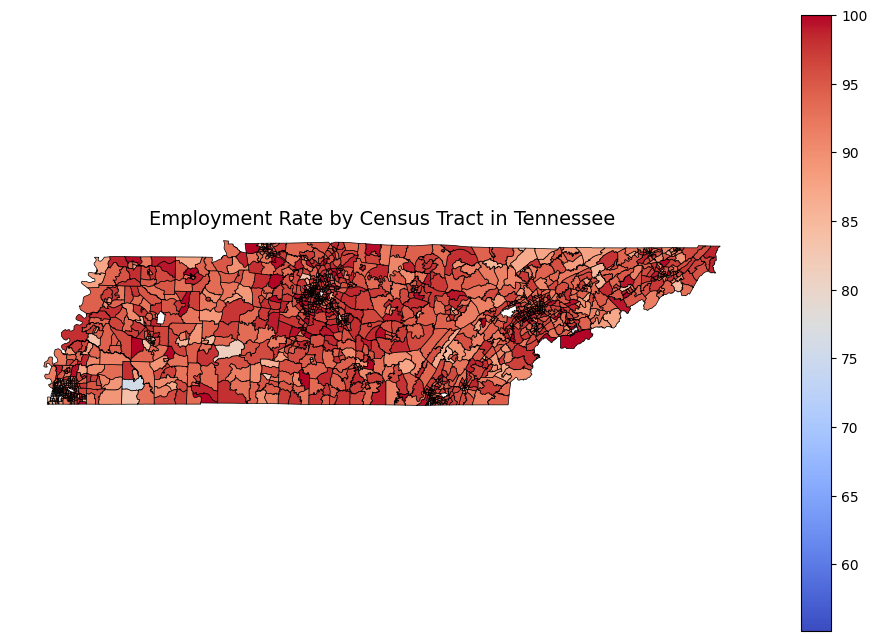

In [58]:
# Plot employment percentage across Tennessee census tracts
fig, ax = plt.subplots(figsize=(12, 8))
tennesee_gdf.plot(column='ACS_PCT_EMPLOYED', cmap='coolwarm', linewidth=0.5, edgecolor='black', legend=True, ax=ax)
ax.set_title('Employment Rate by Census Tract in Tennessee', fontsize=14)
ax.axis('off')  # Hide axis for better visualization
plt.show()


MSE: 17.71, R²: 0.12


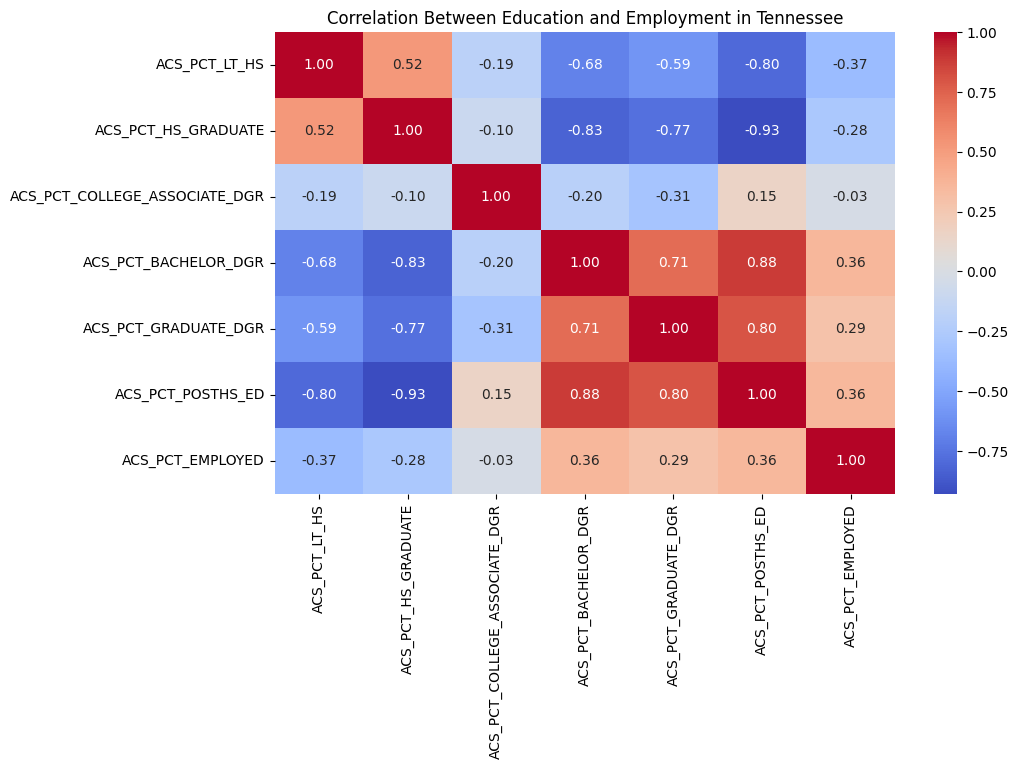

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


features = [
    'ACS_PCT_LT_HS', 
    'ACS_PCT_HS_GRADUATE', 
    'ACS_PCT_COLLEGE_ASSOCIATE_DGR',
    'ACS_PCT_BACHELOR_DGR', 
	
    'ACS_PCT_GRADUATE_DGR', 
	'ACS_PCT_POSTHS_ED', 
	#'ACS_PCT_VET_HS', 
	#'ACS_PCT_VET_COLLEGE', 
    #'ACS_PCT_VET_BACHELOR'
]

target = 'ACS_PCT_EMPLOYED'  # Predicting employment likelihood

# Drop rows with missing values
tennesee_gdf = tennesee_gdf.dropna(subset=features + [target])

# Split data into training and test sets
X = tennesee_gdf[features]
y = tennesee_gdf[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.2f}, R²: {r2:.2f}')

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(tennesee_gdf[features + [target]].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Education and Employment in Tennessee')
plt.show()